In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
import torch
import torch.nn as nn
import torch.nn.functional as F

In [3]:
os.chdir('/content/drive/MyDrive/Master Thesis/src')
from mnist_utils import load_and_transform_mnist, transform_labels_to_binary
from trainers import *
from plots import *

In [4]:
os.chdir('/content/drive/MyDrive/Master Thesis')

MNIST_PATH = '/content/drive/MyDrive/datasets'
RESULTS_PATH = os.path.join(os.path.join(os.getcwd(), "results"), "layers=2 tanh classes=[6,8]")

In [5]:
new_dim = 10
keep_classes = [6,8]

criterion = nn.BCELoss()

def get_net():
    return nn.Sequential(
        nn.Linear(new_dim,5),
        nn.Tanh(),
        nn.Linear(5,1),
        nn.Sigmoid()
    )

def get_dataset():
    dataset = load_and_transform_mnist(MNIST_PATH, new_dim, keep_classes)
    # the following needed specifically for BCELoss
    dataset["train_targets"] = dataset["train_targets"][..., None].float()
    dataset["test_targets"] = dataset["test_targets"][..., None].float()
    return dataset

# Cubic Newton

In [6]:
CN_trainer = {}

for M_min, max_iters in zip([1e-8, 1e-4, 1e-2], [70, 100, 200]):
    seed = 0
    print_every = 10
    eval_every = 1
    eval_hessian_every = 1
    save_spectrum_every = 10
    save_hessian_every = 20
    save_every = max_iters
    weight_decay = 0.
    # kwargs
    M = 1.0

    model_dir = os.path.join(os.path.join(RESULTS_PATH, "CN"), f"seed={seed} M_min={M_min}")
    print(f"model_dir: {model_dir}")

    torch.manual_seed(seed)
    CN_trainer[M_min] = AdaptiveCubicNewtonTrainer(get_net(), get_dataset(), criterion, weight_decay, model_dir, M,  M_min)
    CN_trainer[M_min].load()
    print_training_stats(CN_trainer[M_min], print_every)
    #_ = CN_trainer[M_min].train(max_iters, print_every, eval_every, eval_hessian_every, save_spectrum_every, save_hessian_every, save_every)

model_dir: /content/drive/MyDrive/Master Thesis/results/layers=2 tanh classes=[6,8]/CN/seed=0 M_min=1e-08
     0: train loss =  0.760753, test loss =  0.756232, M =   1.00000000, time =    0.00 sec, lambda_n = -2.103896
    10: train loss =  0.047377, test loss =  0.051257, M =   0.12500000, time =    1.11 sec, lambda_n = -0.007794
    20: train loss =  0.019768, test loss =  0.031170, M =   0.00097656, time =    2.26 sec, lambda_n = -0.000054
    30: train loss =  0.017419, test loss =  0.029933, M =   0.00003052, time =    3.36 sec, lambda_n =  0.000006
    40: train loss =  0.016891, test loss =  0.031607, M =   0.00195312, time =    4.53 sec, lambda_n = -0.000000
    50: train loss =  0.016747, test loss =  0.032036, M =   0.00000191, time =    5.63 sec, lambda_n =  0.000000
    60: train loss =  0.016658, test loss =  0.030983, M = 1073741824.00000000, time =    7.04 sec, lambda_n =  0.000000
    70: train loss =  0.016658, test loss =  0.030983, M = 34359738368.00000000, time =  

In [7]:
print_test_accuracy(CN_trainer[1e-8])

Best test accuracy: 99.12%
Last test accuracy: 98.96%


In [8]:
print_test_accuracy(CN_trainer[1e-4])

Best test accuracy: 99.12%
Last test accuracy: 98.96%


In [9]:
print_test_accuracy(CN_trainer[1e-2])

Best test accuracy: 99.17%
Last test accuracy: 99.12%


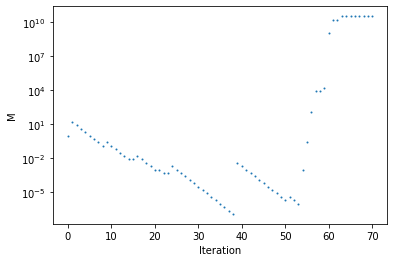

In [10]:
plot_M(CN_trainer[1e-8])

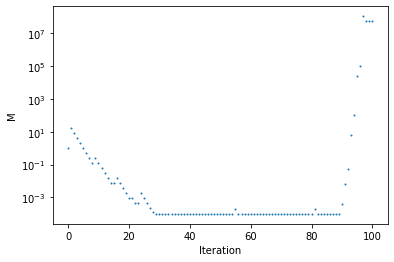

In [11]:
plot_M(CN_trainer[1e-4])

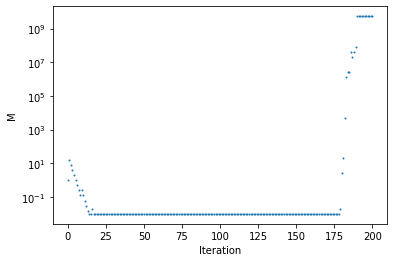

In [12]:
plot_M(CN_trainer[1e-2])

min eigenvalue of (H + Mr/2*I) over all observed iterations:  0.00000013


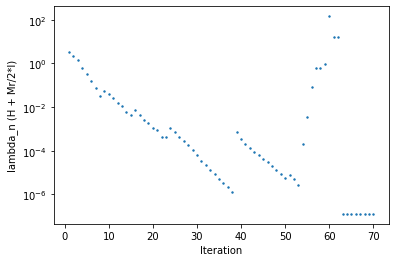

In [13]:
plot_psd_ness(CN_trainer[1e-8])

min eigenvalue of (H + Mr/2*I) over all observed iterations:  0.00004334


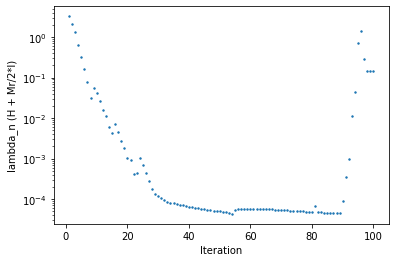

In [14]:
plot_psd_ness(CN_trainer[1e-4])

min eigenvalue of (H + Mr/2*I) over all observed iterations:  0.00000166


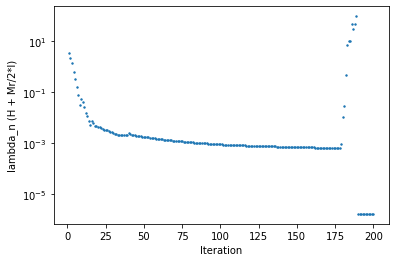

In [15]:
plot_psd_ness(CN_trainer[1e-2])

In [1]:
#visualize_spectrum_evolution(CN_trainer[1e-8], plot_every_iter=1, bin_size=0.2, y_range=(0, 60))

In [2]:
#visualize_spectrum_evolution(CN_trainer[1e-4], plot_every_iter=1, bin_size=0.2, y_range=(0, 60))

In [3]:
#visualize_spectrum_evolution(CN_trainer[1e-2], plot_every_iter=1, bin_size=0.2, y_range=(0, 60))

In [4]:
#visualize_hessians_evolution(CN_trainer[1e-8], plot_every_iter=1)

In [5]:
#visualize_hessians_evolution(CN_trainer[1e-4], plot_every_iter=1)

In [6]:
#visualize_hessians_evolution(CN_trainer[1e-2], plot_every_iter=1)

# plot (Cubic Newton versions)

In [22]:
metrics = [get_metrics(CN_trainer[1e-8]), get_metrics(CN_trainer[1e-4]), get_metrics(CN_trainer[1e-2])]
hessian_metrics = [get_hessian_metrics(CN_trainer[1e-8]), get_hessian_metrics(CN_trainer[1e-4]), get_hessian_metrics(CN_trainer[1e-2])]
labels = ["M_min=1e-8", "M_min=1e-4", "M_min=1e-2"]

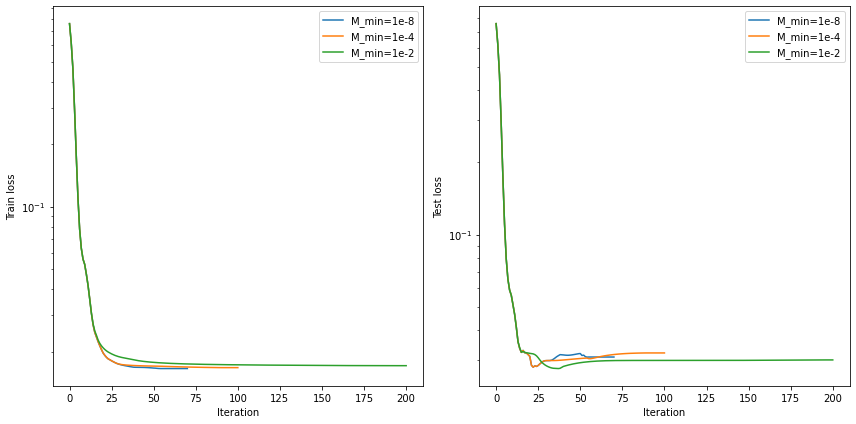

In [23]:
plot_losses(metrics, labels)

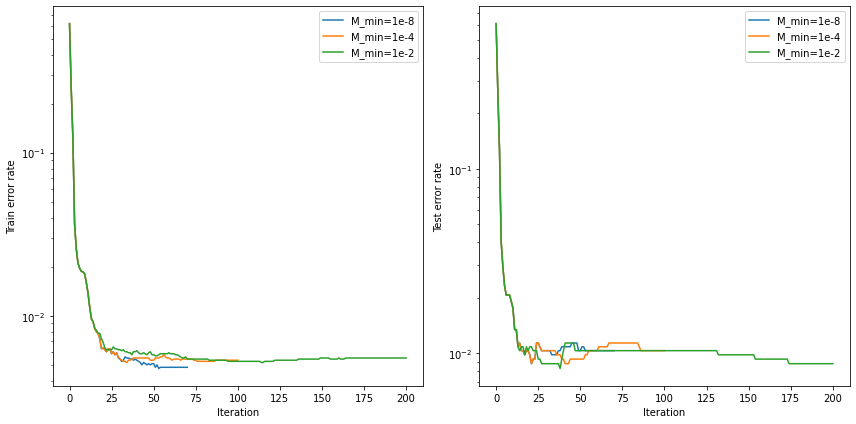

In [24]:
plot_errors(metrics, labels)

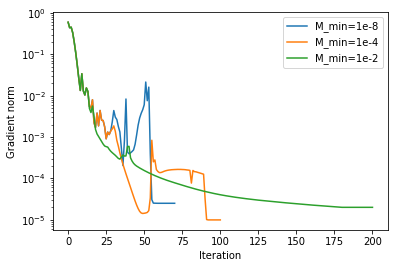

In [25]:
plot_grad_norms(metrics, labels)

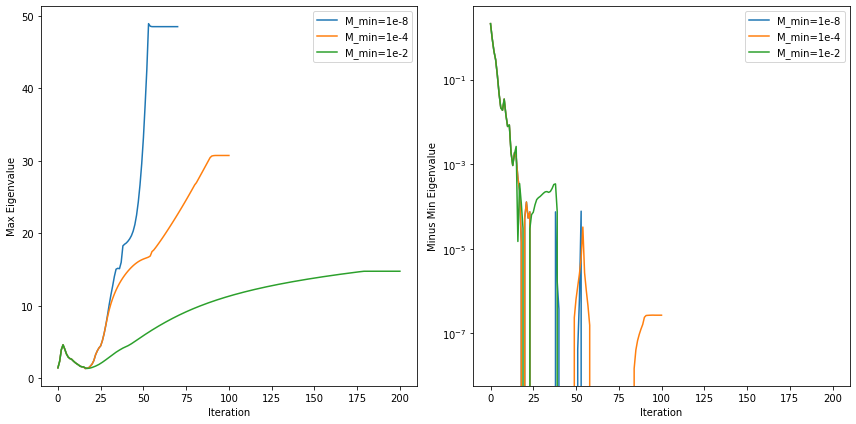

In [26]:
plot_max_min_eigvals(hessian_metrics, labels)

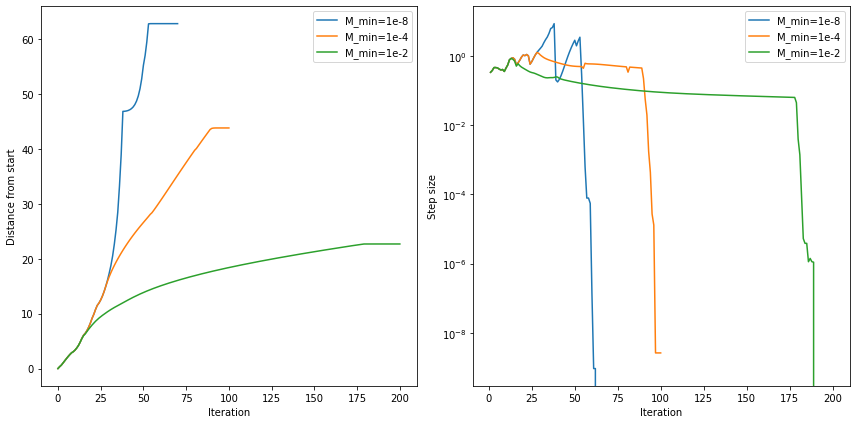

In [27]:
plot_distances(metrics, labels)

Note how nice distance from start correlates with max eigenvalue

It was prabably better to measure the distance not from initial paramaters, but to origin :(

# Gradient Descent

In [28]:
seed = 0
max_iters = 8000
print_every = 1000
eval_every = 10
eval_hessian_every = 50
save_spectrum_every = 500
save_hessian_every = 2000
save_every = 2000
weight_decay = 0.
# kwargs
L = 1.0
L_min = 1e-3

model_dir = os.path.join(os.path.join(RESULTS_PATH, "GD"), f"seed={seed} L_min={L_min}")
print(f"model_dir: {model_dir}")

torch.manual_seed(seed)
GD_trainer = AdaptiveGDTrainer(get_net(), get_dataset(), criterion, weight_decay, model_dir, L, L_min)
GD_trainer.load()
print_training_stats(GD_trainer, print_every)
#_ = GD_trainer.train(max_iters, print_every, eval_every, eval_hessian_every, save_spectrum_every, save_hessian_every, save_every)

model_dir: /content/drive/MyDrive/Master Thesis/results/layers=2 tanh classes=[6,8]/GD/seed=0 L_min=0.001
     0: train loss =  0.760753, test loss =  0.756232, L =   1.00000000, time =    0.00 sec, lambda_n = -2.103896
 1,000: train loss =  0.022429, test loss =  0.033561, L =   0.50000000, time =    5.08 sec, lambda_n = -0.000107
 2,000: train loss =  0.020002, test loss =  0.029758, L =   0.25000000, time =   10.28 sec, lambda_n = -0.000412
 3,000: train loss =  0.019393, test loss =  0.029802, L =   2.00000000, time =   15.54 sec, lambda_n = -0.000472
 4,000: train loss =  0.019107, test loss =  0.029810, L =   2.00000000, time =   21.87 sec, lambda_n = -0.000416
 5,000: train loss =  0.018908, test loss =  0.029754, L =   1.00000000, time =   27.02 sec, lambda_n = -0.000439
 6,000: train loss =  0.018743, test loss =  0.029650, L =   0.50000000, time =   32.59 sec, lambda_n = -0.000567
 7,000: train loss =  0.018594, test loss =  0.029522, L =   4.00000000, time =   39.09 sec, lam

In [29]:
print_test_accuracy(GD_trainer)

Best test accuracy: 98.91%
Last test accuracy: 98.86%


In [7]:
#visualize_spectrum_evolution(GD_trainer, y_range=(0, 60), bin_size=0.1)

In [8]:
#visualize_hessians_evolution(GD_trainer)

# SGD

In [34]:
seed = 0
max_iters = 8000
print_every = 1000
eval_every = 10
eval_hessian_every = 50
save_spectrum_every = 500
save_hessian_every = 2000
save_every = max_iters
weight_decay = 0.
# kwargs
optim_class = torch.optim.SGD
optim_params = {'lr': 0.1}
dataset = get_dataset()
batch_size = 64

model_dir = os.path.join(os.path.join(RESULTS_PATH, "SGD"), f"seed={seed} lr={optim_params['lr']} batch_size={batch_size}")
print(f"model_dir: {model_dir}")

torch.manual_seed(seed)
SGD_trainer = CustomTrainer(get_net(), get_dataset(), criterion, weight_decay, model_dir, optim_class, optim_params, batch_size)
SGD_trainer.load()
print_training_stats(SGD_trainer, print_every)
#_ = SGD_trainer.train(max_iters, print_every, eval_every, eval_hessian_every, save_spectrum_every, save_hessian_every, save_every)

model_dir: /content/drive/MyDrive/Master Thesis/results/layers=2 tanh classes=[6,8]/SGD/seed=0 lr=0.1 batch_size=64
     0: train loss =  0.760753, test loss =  0.756232, time =    0.00 sec, lambda_n = -2.103896
 1,000: train loss =  0.051011, test loss =  0.056072, time =    0.73 sec, lambda_n = -0.025515
 2,000: train loss =  0.042821, test loss =  0.048359, time =    1.45 sec, lambda_n = -0.006622
 3,000: train loss =  0.037442, test loss =  0.044603, time =    2.18 sec, lambda_n = -0.011684
 4,000: train loss =  0.033261, test loss =  0.040774, time =    2.95 sec, lambda_n = -0.002495
 5,000: train loss =  0.032420, test loss =  0.042346, time =    3.67 sec, lambda_n = -0.007179
 6,000: train loss =  0.032096, test loss =  0.041884, time =    4.42 sec, lambda_n = -0.026667
 7,000: train loss =  0.029003, test loss =  0.038550, time =    5.16 sec, lambda_n = -0.002556
 8,000: train loss =  0.028454, test loss =  0.040056, time =    5.89 sec, lambda_n = -0.003650


In [31]:
print_test_accuracy(SGD_trainer)

Best test accuracy: 98.96%
Last test accuracy: 98.91%


In [9]:
#visualize_spectrum_evolution(SGD_trainer, y_range=(0,60), bin_size=0.1)

In [10]:
#visualize_hessians_evolution(SGD_trainer)

# Plots

In [35]:
metrics = [get_metrics(CN_trainer[1e-2]), get_metrics(GD_trainer), get_metrics(SGD_trainer)]
hessian_metrics = [get_hessian_metrics(CN_trainer[1e-2]), get_hessian_metrics(GD_trainer), get_hessian_metrics(SGD_trainer)]
labels = ["CN", "GD", "SGD"]

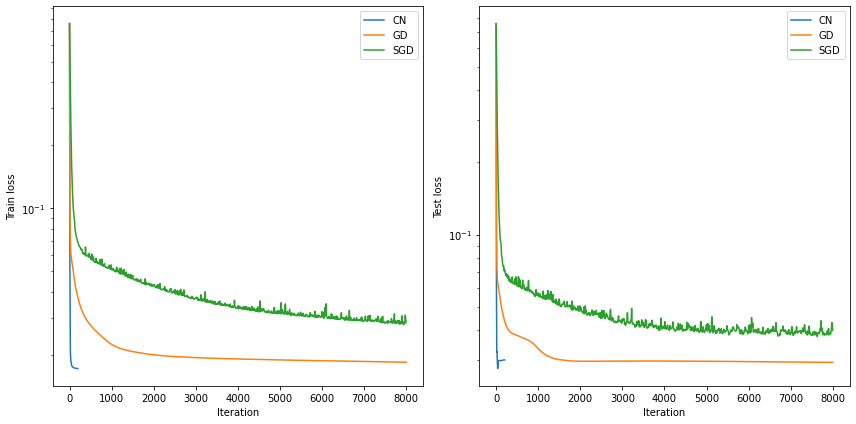

In [36]:
plot_losses(metrics, labels)

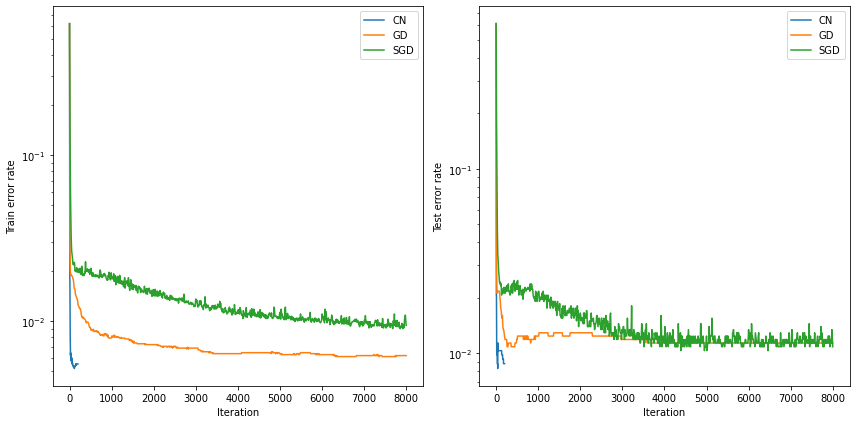

In [37]:
plot_errors(metrics, labels)

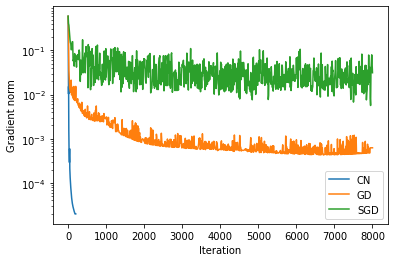

In [38]:
plot_grad_norms(metrics, labels)

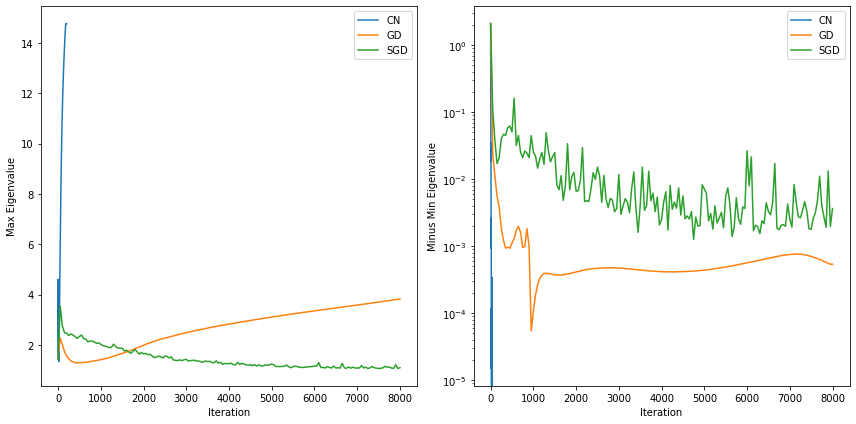

In [39]:
plot_max_min_eigvals(hessian_metrics, labels)

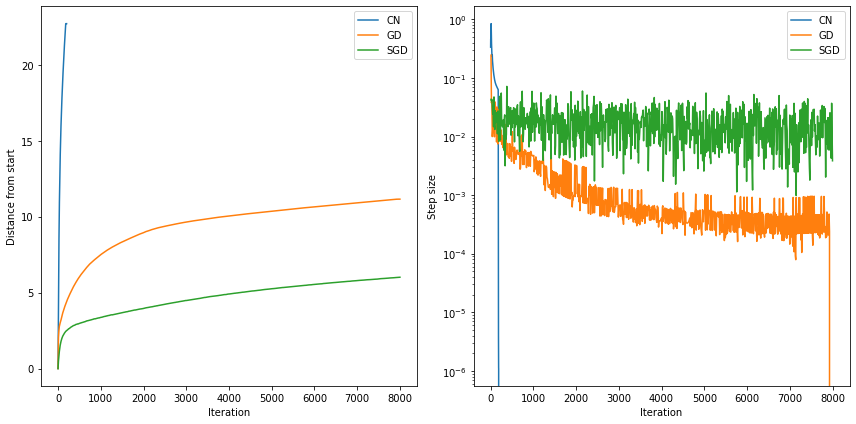

In [40]:
plot_distances(metrics, labels)